# Analysis Deliverable
In this part of the project, we analyze our data, decide which factors should be included in our prediction model, and machine learn a likes-prediction model for Instagram posts made by popular singers.

## Analysis

In [393]:
import pandas as pd
pd.options.display.max_colwidth = 10000000
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First, we must read in the data, remove unnecessary columns and rows, and add relevant columns.

In [394]:
# read in instagram json data
df_main = pd.read_json('../data/final_data.json')

To remove non-image rows, we must filter out posts whose imageUrls lack the substring "1080x1080". We discovered that this string implies the post is a photo, but it does not imply the post is a video. Therefore, we are trading away some of our data points for better data type consistency during analysis.

In [395]:
# drop non-image rows
df_main = df_main[df_main['imageUrl'].map(lambda x: "1080x1080" in x)]

The next set of rows to drop are ones whose users are not verified. We perform this filtering because we found that only a tiny percentage of the users were not verified, so, once again, we sacrificed some data points for better data consistency. Directly below is the justification.

In [396]:
# record non-verified information
df_nv = df_main[df_main['verified'] == False]
nv_posts = df_nv.shape[0]
df_nv = df_nv[['username']].groupby('username').count()
nv_count = df_nv.shape[0]
# record total information
tot_posts = df_main.shape[0]
tot_count = df_main['username'].value_counts(normalize=True).shape[0]
# calculate accounts ratios
r1 = nv_count / tot_count * 100
# calculate posts ratios
r2 = nv_posts / tot_posts * 100
# print out non-verified ratio
print("Only %{r1:.2f} of the accounts are non-verified, and only %{r2:.2f} of all posts are made by non-verified accounts. We chose to drop these values.".format(r1 = r1, r2 = r2))

Only %2.96 of the accounts are non-verified, and only %1.85 of all posts are made by non-verified accounts. We chose to drop these values.


Now, we can proceed to drop those rows.

In [397]:
df_main = df_main[df_main['verified'] == True]

Next, we need a caption length column, as we believe caption length may potentially influence a post's number of likes. This column will hold the number of characters in each post's caption (0 if no caption).

In [398]:
df_main['captionLength'] = df_main['firstComment'].map(lambda x: 0 if x == None else len(x))

Now, we can remove non-essential columns, or columns we will not be later using in analysis or machine learning. In particular, these are locationName, firstComment, url, imageUrl, verified, and followsCount.

In [399]:
df_main = df_main.drop(['locationName', 'firstComment', 'url', 'imageUrl', 'verified', 'followsCount'], axis=1)

We must then add a column containing normalized likes values for each post, so the likes counts of posts from users with varying followers counts can be roughly compared. We are very aware of the bias present in this step, but our goal is to get a general sense of which variables may potentially influence our prediction model, not to prove correlation. Followers count is also probably the most impactful of the variables we are considering, so we assume it 'absorbs' most of the bias and let it slide.

In [400]:
df_main['normalizedLikes'] = df_main['likesCount'] / df_main['followersCount']

We will now add three sets of indicator columns, one for the post's time of day, another for the day on which the post was made, and a third for the month in which the post was made.

In [401]:
# time-of-day indicators
df_main['early'] = df_main['timestamp'].map(lambda x: 0 <= x.hour < 3)
df_main['dawn'] = df_main['timestamp'].map(lambda x: 3 <= x.hour < 6)
df_main['sunrise'] = df_main['timestamp'].map(lambda x: 6 <= x.hour < 9)
df_main['morning'] = df_main['timestamp'].map(lambda x: 9 <= x.hour < 12)
df_main['noon'] = df_main['timestamp'].map(lambda x: 12 <= x.hour < 15)
df_main['afternoon'] = df_main['timestamp'].map(lambda x: 15 <= x.hour < 18)
df_main['sunset'] = df_main['timestamp'].map(lambda x: 18 <= x.hour < 21)
df_main['night'] = df_main['timestamp'].map(lambda x: 21 <= x.hour < 24)
# day of week indicators
df_main['sunday'] = df_main['timestamp'].map(lambda x: x.day_name() == 'Sunday')
df_main['monday'] = df_main['timestamp'].map(lambda x: x.day_name() == 'Monday')
df_main['tuesday'] = df_main['timestamp'].map(lambda x: x.day_name() == 'Tuesday')
df_main['wednesday'] = df_main['timestamp'].map(lambda x: x.day_name() == 'Wednesday')
df_main['thursday'] = df_main['timestamp'].map(lambda x: x.day_name() == 'Thursday')
df_main['friday'] = df_main['timestamp'].map(lambda x: x.day_name() == 'Friday')
df_main['saturday'] = df_main['timestamp'].map(lambda x: x.day_name() == 'Saturday')
# month indicators
df_main['january'] = df_main['timestamp'].map(lambda x: x.month == 1)
df_main['february'] = df_main['timestamp'].map(lambda x: x.month == 2)
df_main['march'] = df_main['timestamp'].map(lambda x: x.month == 3)
df_main['april'] = df_main['timestamp'].map(lambda x: x.month == 4)
df_main['may'] = df_main['timestamp'].map(lambda x: x.month == 5)
df_main['june'] = df_main['timestamp'].map(lambda x: x.month == 6)
df_main['july'] = df_main['timestamp'].map(lambda x: x.month == 7)
df_main['august'] = df_main['timestamp'].map(lambda x: x.month == 8)
df_main['september'] = df_main['timestamp'].map(lambda x: x.month == 9)
df_main['october'] = df_main['timestamp'].map(lambda x: x.month == 10)
df_main['november'] = df_main['timestamp'].map(lambda x: x.month == 11)
df_main['december'] = df_main['timestamp'].map(lambda x: x.month == 12)

Lastly, let's print out the first three rows of our updated dataframe to ensure our changes are correct.

In [402]:
df_main.head(3)

,username,timestamp,likesCount,followersCount,isBusinessAccount,postsCount,captionLength,normalizedLikes,early,dawn,...,march,april,may,june,july,august,september,october,november,december
0,billieeilish,2020-02-19 19:01:46,9038466,57162466,False,423,7,0.158119,False,False,...,False,False,False,False,False,False,False,False,False,False
3,billieeilish,2020-02-11 03:26:25,9642834,57162466,False,423,29,0.168692,False,True,...,False,False,False,False,False,False,False,False,False,False
4,billieeilish,2020-02-04 06:55:44,8489883,57162466,False,423,0,0.148522,False,False,...,False,False,False,False,False,False,False,False,False,False


Looks good! Let's proceed to do some analysis (and vizualization) to determine which variables will be worth considering in the machine learning phase.

### Followers Count

We believe a user's following size is a large factor in determining the number of likes a post made by him/her receives. In this section, we discover that the average likes-followers ratio (normalized likes value) decreases exponentially as the number of followers increases. This suggests that we should potentially treat our likes prediction model partially as poly-order exponential function of the number of followers in the machine learning phase (note the logx=True parameter in fitting with seaborn's regplot).

In [403]:
# extract relevant columns
df_avgs = df_main[['username', 'followersCount', 'likesCount', 'normalizedLikes']]
# group by followers and take averages (note: followersCount does not change)
df_avgs = df_avgs.groupby('username').mean()
# print out df_avgs
df_avgs.head(3)

,followersCount,likesCount,normalizedLikes
username,,,
21savage,10886991.0,874370.476190,0.080313
50cent,25414459.0,217091.992647,0.008542
7_luhan_m,11808136.0,840323.000000,0.071165


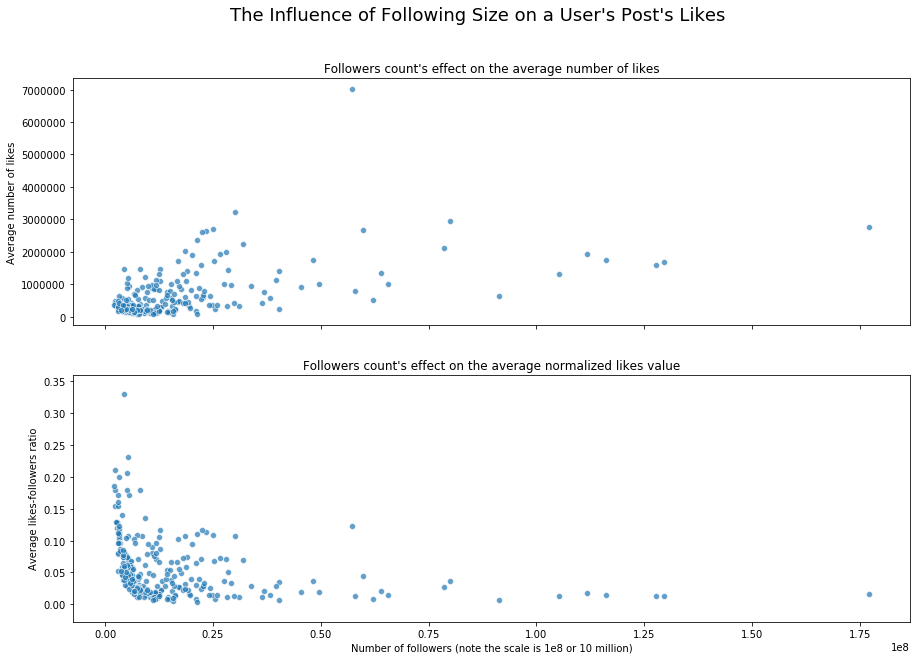

In [404]:
# create two plots showing the effect of followers count on likes count
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.scatterplot(x=df_avgs['followersCount'], y=df_avgs['likesCount'], ax=axes[0], alpha = 0.7)
sns.scatterplot(x=df_avgs['followersCount'], y=df_avgs['normalizedLikes'], ax=axes[1], alpha = 0.7)
axes[0].set_title('Followers count\'s effect on the average number of likes')
axes[0].set_ylabel('Average number of likes')
axes[1].set_title('Followers count\'s effect on the average normalized likes value')
axes[1].set_ylabel('Average likes-followers ratio')
plt.xlabel('Number of followers (note the scale is 1e8 or 10 million)')
fig.suptitle('Influence of Following Size on a User\'s Post\'s Likes', fontsize=18)
plt.show()

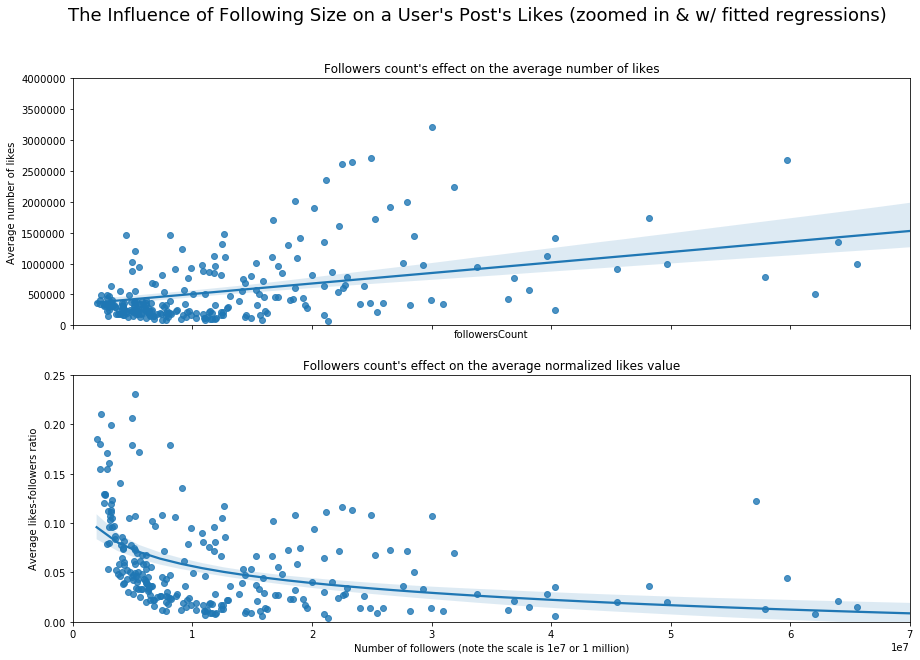

In [405]:
# show the same two graphs at a smaller scale
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.regplot(x=df_avgs['followersCount'], y=df_avgs['likesCount'], ax=axes[0])
sns.regplot(x=df_avgs['followersCount'], y=df_avgs['normalizedLikes'], ax=axes[1], logx=True)
axes[0].set_title('Followers count\'s effect on the average number of likes')
axes[0].set_ylabel('Average number of likes')
axes[0].set_ylim(0, 4e6)
axes[1].set_title('Followers count\'s effect on the average normalized likes value')
axes[1].set_ylabel('Average likes-followers ratio')
axes[1].set_ylim(0, 0.25)
plt.xlabel('Number of followers (note the scale is 1e7 or 1 million)')
plt.xlim(0, 7e7)
fig.suptitle('Influence of Following Size on a User\'s Post\'s Likes (zoomed in & w/ fitted regressions)', fontsize=18)
plt.show()

Double check possible relation using logarithmic manipulation and linear regression. We are expecting a negative slope...

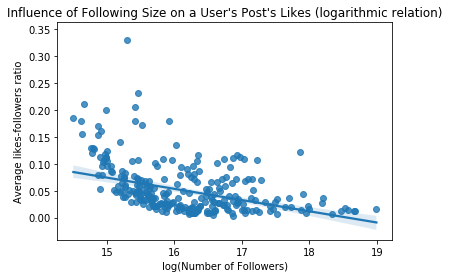

In [407]:
# show the same two graphs at a smaller scale
sns.regplot(x=df_avgs['followersCount'].map(np.log), y=df_avgs['normalizedLikes'], robust=True)
plt.title('Influence of Following Size on a User\'s Post\'s Likes (logarithmic relation)')
plt.xlabel('log(Number of Followers)')
plt.ylabel('Average likes-followers ratio')
plt.show()

... and it looks acceptable! There is still some curvature in the data, suggesting that we may be observing a poly-exponential relation between followers count and the normalized likes value. This means that the relation between followers count and likes value could also be poly-exponential.

### Caption Length

We believe the length of the caption given to a post may influence the number of likes the post receives. In this section, no clear relation was found between caption length and likes count for a post. It is possible that there is a slight negative exponential fit (revealed in Lowess regression), but there is far too much noise in the data to be sure. This suggests we should try including caption length in the machine learning phase, but it is unlikely to contribute much to the prediction task, and we may likely remove it from our final list of parameters.

In [408]:
# group by caption length
df_caps = df_main[['captionLength', 'normalizedLikes']]
df_caps = df_caps.groupby('captionLength').mean().reset_index()
# print df_caps
df_caps.head(3)

,captionLength,normalizedLikes
0,0,0.052918
1,1,0.049856
2,2,0.051367


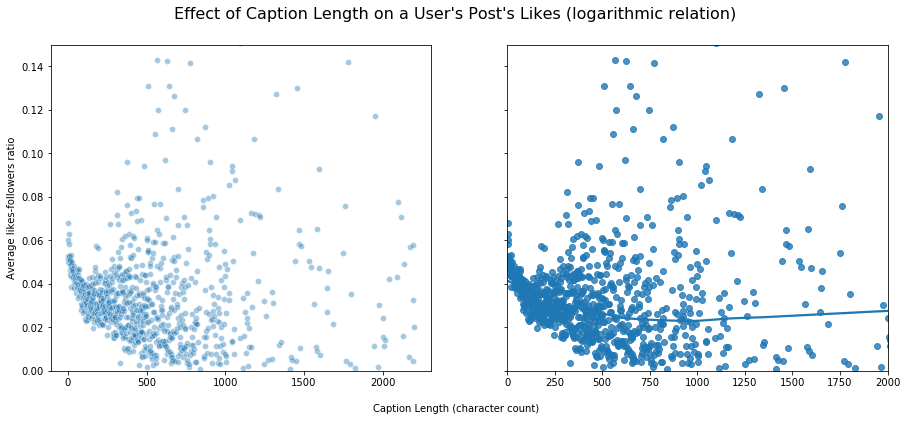

In [431]:
# plot the scatter and show logarithmic relation, note that the first row had to be dropped
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.scatterplot(x=df_caps['captionLength'], y=df_caps['normalizedLikes'], alpha=0.4, ax=axes[0])
sns.regplot(x=df_caps[1:]['captionLength'], y=df_caps[1:]['normalizedLikes'], lowess=True, ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('Average likes-followers ratio')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(0, 2000)
axes[1].set_ylim(0, 0.15)
fig.text(0.5, 0.03, 'Caption Length (character count)', ha='center')
fig.text(0.5, 0.94, 'Effect of Caption Length on a User\'s Post\'s Likes (logarithmic relation)', ha='center', size=16)
plt.show()

Double check exponential relation using logarithmic manipulation and linear regression.

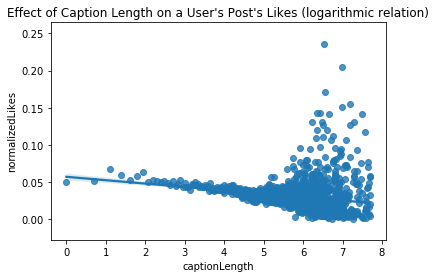

In [432]:
# plot the logarithmic relation between 
sns.regplot(x=df_caps[1:]['captionLength'].map(np.log), y=df_caps[1:]['normalizedLikes'], robust=True)
plt.title('Effect of Caption Length on a User\'s Post\'s Likes (logarithmic relation)')
plt.show()

The negative trend is more pronounced in this example, but the data still seems to "fan out" as the caption length increases, just as was observed in the original data. Despite the high variance on the right hand side, this still provides a stronger case for including caption length in the machine learning phase.

### Time of Day
We believe that the time of day when the post was made was may effect the number of likes it receives.

In [437]:
df_time = df_main[['early', 'dawn', 'sunrise', 'morning', 'noon', 'afternoon', 'sunset', 'night', 'normalizedLikes']]
df_time.head(3)

,early,dawn,sunrise,morning,noon,afternoon,sunset,night,normalizedLikes
0,False,False,False,False,False,False,True,False,0.158119
3,False,True,False,False,False,False,False,False,0.168692
4,False,False,True,False,False,False,False,False,0.148522


In [8]:
# plot the bar chart
df_time.groupby('time').mean()
time_order = ['early', 'dawn', 'sunrise', 'morning', 'noon', 'afternoon', 'sunset', 'night']
# plt.bar(df_time['time'], df_time['normalizedLikes'])
# plt.show()

### Time of Week
We believe what day of the week when the post was made was may effect the number of likes it receives.

### Time of Year
We believe that the time of the year (month) when the post was made was may effect the number of likes it receives

## Training The Model

In [11]:
import statsmodels.api as sm
from statsmodels.tools import eval_measures
from sklearn.model_selection import train_test_split

In [14]:
# extract independent variables
X = df_main[['followersCount', 'early', 'dawn', 'sunrise', 'morning', 'noon', 'afternoon', 'sunset', 'night']].values.tolist()
# extract dependent variables
y = df_main['likesCount'].tolist()
# create test / train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
# train model
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()
# generate predictions
# train_predictions = results.predict(X_train)
# test_predictions = results.predict(X_test)
# print MSEs and R-squared
# print("Training MSE: ", eval_measures.mse(y_train, train_predictions))
# print("Testing MSE: ", eval_measures.mse(y_test, test_predictions))
# print("R-squared: ", results.rsquared)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     692.5
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:25:36   Log-Likelihood:            -2.6537e+05
No. Observations:               17814   AIC:                         5.308e+05
Df Residuals:                   17805   BIC:                         5.308e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.74e+05   6250.033     43.836      0.000    2.62e+05    2.86e+05
x1             0.0156      0.000     73.547      0.000       0.015       0.016
x2          4.312e+04   1.43e+04      3.021      0.003    1.51e+04    7.11e+04
x3          1.231e+05   1.63e+04      7.546      0.000    9.11e+04    1.55e+05
x4          1.133e+05   1.92e+04      5.911      0.000    7.57e+04    1.51e+05
x5          6.649e+04   1.84e+04      3.609      0.000    3.04e+04    1.03e+05
x6          6.253e+04   1.54e+04      4.068      0.000    3.24e+04    9.27e+04
x7         -6.074e+04   1.25e+04     -4.872      0.000   -8.52e+04   -3.63e+04
x8         -2.887e+04    1.2e+04     -2.414      0.016   -5.23e+04   -5426.526
x9         -4.492e+04   1.24e+04     -3.622      0.000   -6.92e+04   -2.06e+04
==============================================================================
Omnibus:                    14137.248   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           482780.486
Skew:                           3.573   Prob(JB):                         0.00
Kurtosis:                      27.482   Cond. No.                     2.62e+23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.66e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""